In [1]:
import re
import os
import pickle
import time
import numpy as np
import pandas as pd
from pathlib import Path
from Core.inputparse import Parser
from SALib.sample.morris import sample as morris_sample

In [22]:
tmap = pd.ExcelFile('Data/Techmap/DEModel_V2.xlsx')
df = pd.read_excel(tmap,"ConversionSubProcess",skiprows=[1,2]).drop(columns=['is_storage', 'efficiency', 'technical_availability', 'output_profile', 'availability_profile'])

In [27]:
cs_names = np.array([])
cs_values = np.array([])
pattern = re.compile(r'\s*;\s*|\s+')
for i in range(len(df)):
    if df.iloc[i]["conversion_process_name"] == 'DEBUG':
        break
    else:
        if type(df.iloc[i]['conversion_process_name']) != str:
            continue
        cs = df.iloc[i].dropna()
        cs_name = f'{cs["conversion_process_name"]}&{cs["commodity_in"]}&{cs["commodity_out"]}'
        remaining_columns = cs.index
        for col in remaining_columns[4:]:
            value = cs[col]
            if type(value) == str:
                year_values = pattern.split(value[1:-1])
                for j in range(0, len(year_values), 2):
                    year_value = -1 if year_values[j+1] == 'NaN' else float(year_values[j+1])
                    cs_names = np.append(cs_names, f'{cs_name}&{col}&{year_values[j]}')
                    cs_values = np.append(cs_values, year_value)
            else:
                cs_names = np.append(cs_names, f'{cs_name}&{col}')
                cs_values = np.append(cs_values, value)

In [28]:
cs_names

array(['Import_Biomass&Dummy&Biomass&spec_co2',
       'Import_Biomass&Dummy&Biomass&opex_cost_energy',
       'Import_Biomass&Dummy&Biomass&max_eout',
       'Import_Coal&Dummy&Coal&spec_co2',
       'Import_Coal&Dummy&Coal&opex_cost_energy&2016',
       'Import_Coal&Dummy&Coal&opex_cost_energy&2030',
       'Import_Coal&Dummy&Coal&opex_cost_energy&2050',
       'Import_Crude_Oil&Dummy&Crude_Oil&spec_co2',
       'Import_Crude_Oil&Dummy&Crude_Oil&opex_cost_energy&2016',
       'Import_Crude_Oil&Dummy&Crude_Oil&opex_cost_energy&2030',
       'Import_Crude_Oil&Dummy&Crude_Oil&opex_cost_energy&2050',
       'Import_Lignite&Dummy&Lignite&spec_co2',
       'Import_Lignite&Dummy&Lignite&opex_cost_energy',
       'Import_Natural_Gas&Dummy&Natural_Gas&spec_co2',
       'Import_Natural_Gas&Dummy&Natural_Gas&opex_cost_energy&2016',
       'Import_Natural_Gas&Dummy&Natural_Gas&opex_cost_energy&2030',
       'Import_Natural_Gas&Dummy&Natural_Gas&opex_cost_energy&2050',
       'Import_Uranium&Dumm

In [29]:
original_params = {}
modified_params = {}

# TODO revise these definitions
fraction_params = ['efficiency_charge', 'out_frac_min', 'out_frac_max', 'in_frac_min', 'in_frac_max']
params_5_percent = ['efficiency_charge', 'c_rate', 'technical_lifetime']
params_10_percent = ['spec_co2', 'opex_cost_power', 'max_eout', 'min_eout']
params_20_percent = ['opex_cost_energy', 'capex_cost_power']
problem_params = ['cap_res_max', 'cap_res_min', 'cap_min', 'cap_max']+params_10_percent+params_5_percent+fraction_params
for i in range(len(cs_names)):
    if any(substring in cs_names[i] for substring in params_20_percent):
        percentage_range = 0.2
    elif any(substring in cs_names[i] for substring in params_5_percent):
        percentage_range = 0.05
    else:
        percentage_range = 0.1
    is_fraction = True if any(substring in cs_names[i] for substring in fraction_params) else False
        
    original_params[cs_names[i]] = cs_values[i]
    
    if not (cs_values[i] == 0 or cs_values[i] == 1 or cs_values[i] == -1) and not(any(substring in cs_names[i] for substring in problem_params)):
        value_range = [cs_values[i]*(1-percentage_range), cs_values[i]*(1+percentage_range)]
        if is_fraction:
            np.clip(value_range,0,1)
        modified_params[cs_names[i]] = value_range

In [32]:
problem = {
    'num_vars': len(modified_params),
    'names': list(modified_params.keys()),
    'bounds': list(modified_params.values())
}
try:
    objects = []
    with (open('GSAResults/var_names.pkl', "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    out_names = objects[0]
    problem['outputs'] = out_names
except:
    pass

In [35]:
# Generate samples
trajectories = 100
optimal_trajectories = 2
start_time = time.time()
samples = morris_sample(problem, trajectories, optimal_trajectories=optimal_trajectories)
sampling_time = time.time() - start_time

In [36]:
base_cs = pd.read_excel(tmap,"ConversionSubProcess",  skiprows=[1, 2])
input_dfs = []

In [38]:
for i in range(len(samples)):
    new_params = original_params
    for idx, key in enumerate(modified_params):
        new_params[key] = samples[i][idx]
    mod_cs = base_cs.copy()
    last_yearly = ''
    yearly_input = []
    range_names = list(new_params.keys())
    for j in range(len(range_names)):
        split_name = range_names[j].split('&')
        is_yearly = False if len(split_name) == 4 else True
        if is_yearly:
            if range_names[j][:-5] != last_yearly:
                last_yearly = range_names[j][:-5]
                value = new_params[range_names[j]] if new_params[range_names[j]] != -1 else 'NaN'
                yearly_input = f'[{split_name[-1]} {value}'
            else:
                value = new_params[range_names[j]] if new_params[range_names[j]] != -1 else 'NaN'
                yearly_input = f'{yearly_input};{split_name[-1]} {value}'
                if j != len(range_names) - 1:
                    if range_names[j+1][:-5] != range_names[j][:-5]:
                        yearly_input = f'{yearly_input}]'
                        mod_cs.loc[(mod_cs['conversion_process_name']==split_name[0])&
                                (mod_cs['commodity_in']==split_name[1])&
                                (mod_cs['commodity_out']==split_name[2]),split_name[3]] = yearly_input
        else:
            value = new_params[range_names[j]] if new_params[range_names[j]] != -1 else 'NaN'
            mod_cs.loc[(mod_cs['conversion_process_name']==split_name[0])&
                    (mod_cs['commodity_in']==split_name[1])&
                    (mod_cs['commodity_out']==split_name[2]),split_name[3]] = value
    input_dfs.append(mod_cs)

In [39]:
test = input_dfs[0]

In [15]:
parser = Parser('DEModel_V2', techmap_dir_path='Data/Techmap', ts_dir_path='Data/TimeSeries', scenario='Base')
parsed_samples = []
for idf in input_dfs:
    parser.parse(idf)
    parsed_samples.append(parser.get_input())

In [3]:
# sample_input = []
# with (open(f'GSASamples/dfs_298.pkl', "rb")) as openfile:
#     while True:
#         try:
#             sample_input.append(pickle.load(openfile))
#         except EOFError:
#             break
# sample_without = sample_input[0][0]

sample_input = []
with (open(f'GSASamples/dfs_298.pkl', "rb")) as openfile:
    while True:
        try:
            sample_input.append(pickle.load(openfile))
        except EOFError:
            break
sample_with = sample_input[0][0]
    

In [5]:
from SALib.analyze.morris import analyze as morris_analyze
path = 'GSAResults/DEModel_V2-Base-26-02-24_21-39'
problem_path = f'{path}/problem_def.pkl'
X_path = f'{path}/X.pkl'
Y_path = f'{path}/Y.pkl'

In [6]:
temp = []
with (open(problem_path, "rb")) as openfile:
    while True:
        try:
            temp.append(pickle.load(openfile))
        except EOFError:
            break
problem = temp[0]
param_names = temp[0]['names']

In [7]:
temp = []
with (open(X_path, "rb")) as openfile:
    while True:
        try:
            temp.append(pickle.load(openfile))
        except EOFError:
            break
X = temp[0]

In [8]:
temp = []
with (open(Y_path, "rb")) as openfile:
    while True:
        try:
            temp.append(pickle.load(openfile))
        except EOFError:
            break
Y = temp[0]
var_names = temp[0]['output_var_names']

In [9]:
feasible_runs = len(Y['infeasible']) - np.sum(Y['infeasible'])
feasible_Y = np.empty((feasible_runs,len(Y['runs'][1])))
feasible_X = np.empty((feasible_runs,len(X[0])))

idx = 0
for key in Y['runs']:
    if not Y['infeasible'][key-1]:
        feasible_Y[idx] = Y['runs'][key]
        feasible_X[idx] = X[key-1]
        idx += 1

if feasible_runs % 2 != 0:
    feasible_Y = feasible_Y[:-1]
    feasible_X = feasible_X[:-1]

In [10]:
column_names = param_names
df = pd.DataFrame(columns=column_names)

for i in range(feasible_Y.shape[1]):
    Si = morris_analyze(problem=problem,X=feasible_X,Y=feasible_Y[:,i])
    # Getting only mu_star because, it's a more reliable parameter than mu, and sigma is useful for interactions, which will be better
    # assessed in the Sobol method. Here we just need mu_star
    if np.max(Si['mu_star']) == 0:
        df.loc[var_names[i]] = list(Si['mu_star'])
    else:
        df.loc[var_names[i]] = list(Si['mu_star'] / np.max(Si['mu_star']))

In [11]:
rows_to_drop = []
cols_to_drop = []
relevant = []
for i in range(len(df)):
    if np.max(df.iloc[i]) < 0.5:
        rows_to_drop.append(var_names[i])
        continue
    top_40 = df.iloc[i].sort_values(ascending=False).head(40)
    relevant.append(list(top_40.index))
for j in range(df.shape[1]):
    if np.max(df.iloc[:,j]) < 0.5:
        cols_to_drop.append(param_names[j])
df = df.drop(rows_to_drop)
df = df.drop(cols_to_drop,axis=1)
    

In [33]:
test = df.sum(axis=0)

In [34]:
top_40_total_contribution = list(test.sort_values(ascending=False).head(40).index)

In [14]:
flat_relevant = [item for sublist in relevant for item in sublist]

In [15]:
from collections import Counter
counts = Counter(flat_relevant)

In [16]:
top_40_values = [value for value, count in counts.most_common(40)]

In [27]:
set1 = set(top_40_total_contribution)
set2 = set(top_40_values)

In [29]:
len(set1.intersection(set2))

32

In [35]:
sobol_params = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/sobol_params.pkl', "rb")) as openfile:
    while True:
        try:
            sobol_params.append(pickle.load(openfile))
        except EOFError:
            break
sobol_params = sobol_params[0]

In [2]:
df_morris = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/morris_results.pkl', "rb")) as openfile:
    while True:
        try:
            df_morris.append(pickle.load(openfile))
        except EOFError:
            break
df_morris = df_morris[0]

In [4]:
df_S1 = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/S1.pkl', "rb")) as openfile:
    while True:
        try:
            df_S1.append(pickle.load(openfile))
        except EOFError:
            break
df_S1 = df_S1[0]
df_S2 = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/S2.pkl', "rb")) as openfile:
    while True:
        try:
            df_S2.append(pickle.load(openfile))
        except EOFError:
            break
df_S2 = df_S2[0]
df_ST = []
with (open(f'GSAResults/DEModel_V2-Base-26-02-24_21-39/ST.pkl', "rb")) as openfile:
    while True:
        try:
            df_ST.append(pickle.load(openfile))
        except EOFError:
            break
df_ST = df_ST[0]

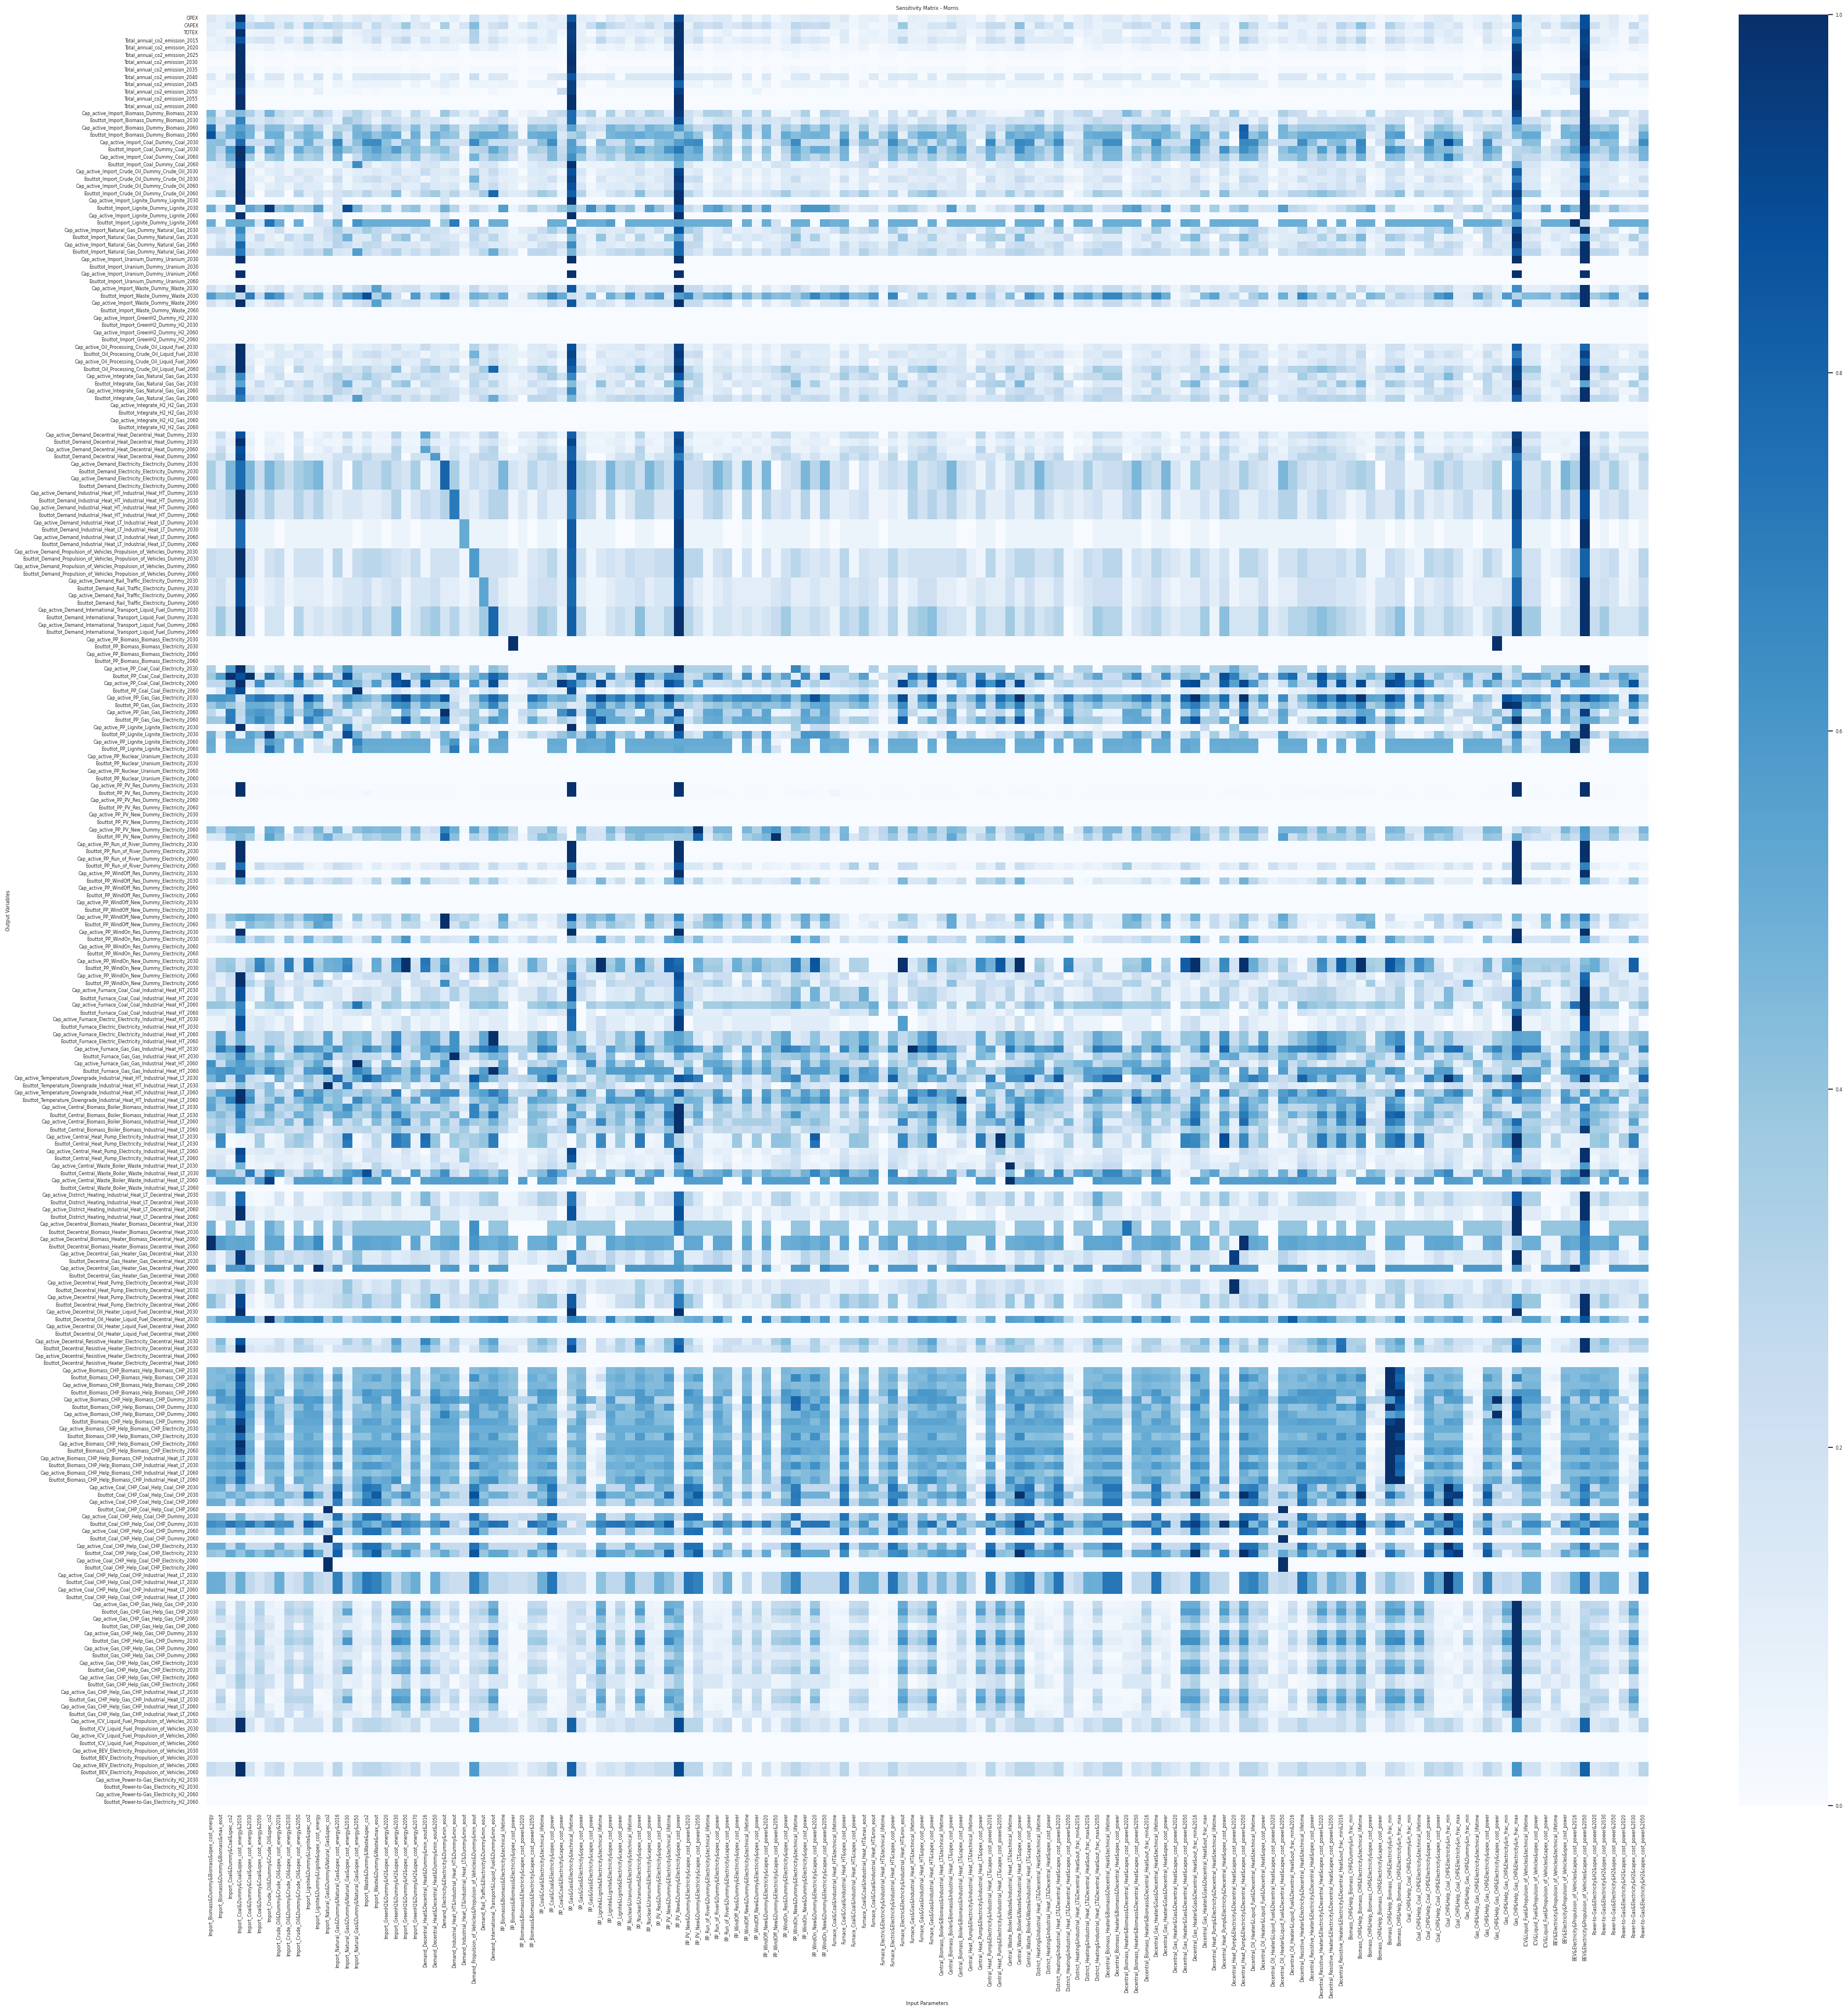

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=0.5)
sns.heatmap(df_morris, annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Morris')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

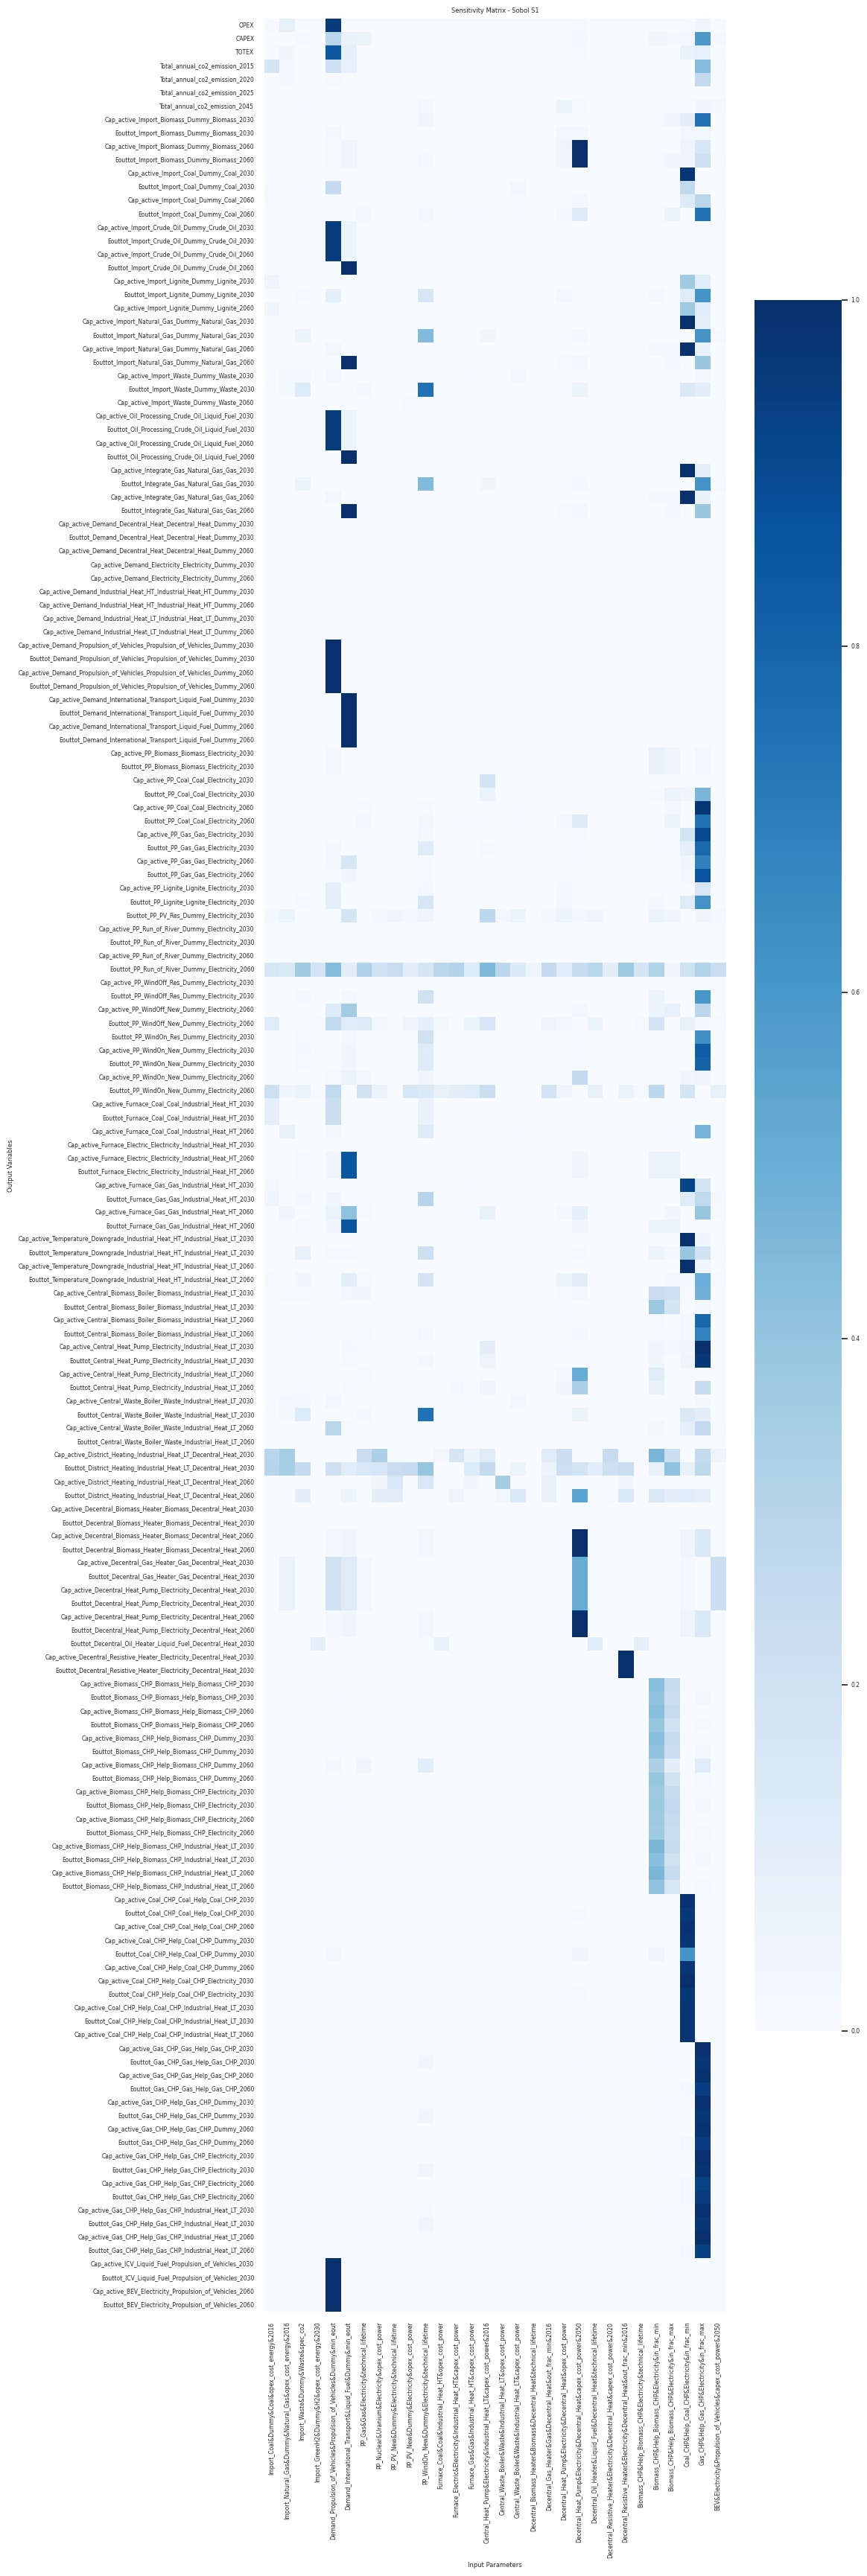

In [11]:
# Plot heatmap
plt.figure(figsize=(10, 40))
sns.set(font_scale=0.5)
sns.heatmap(df_S1.dropna(), annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol S1')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

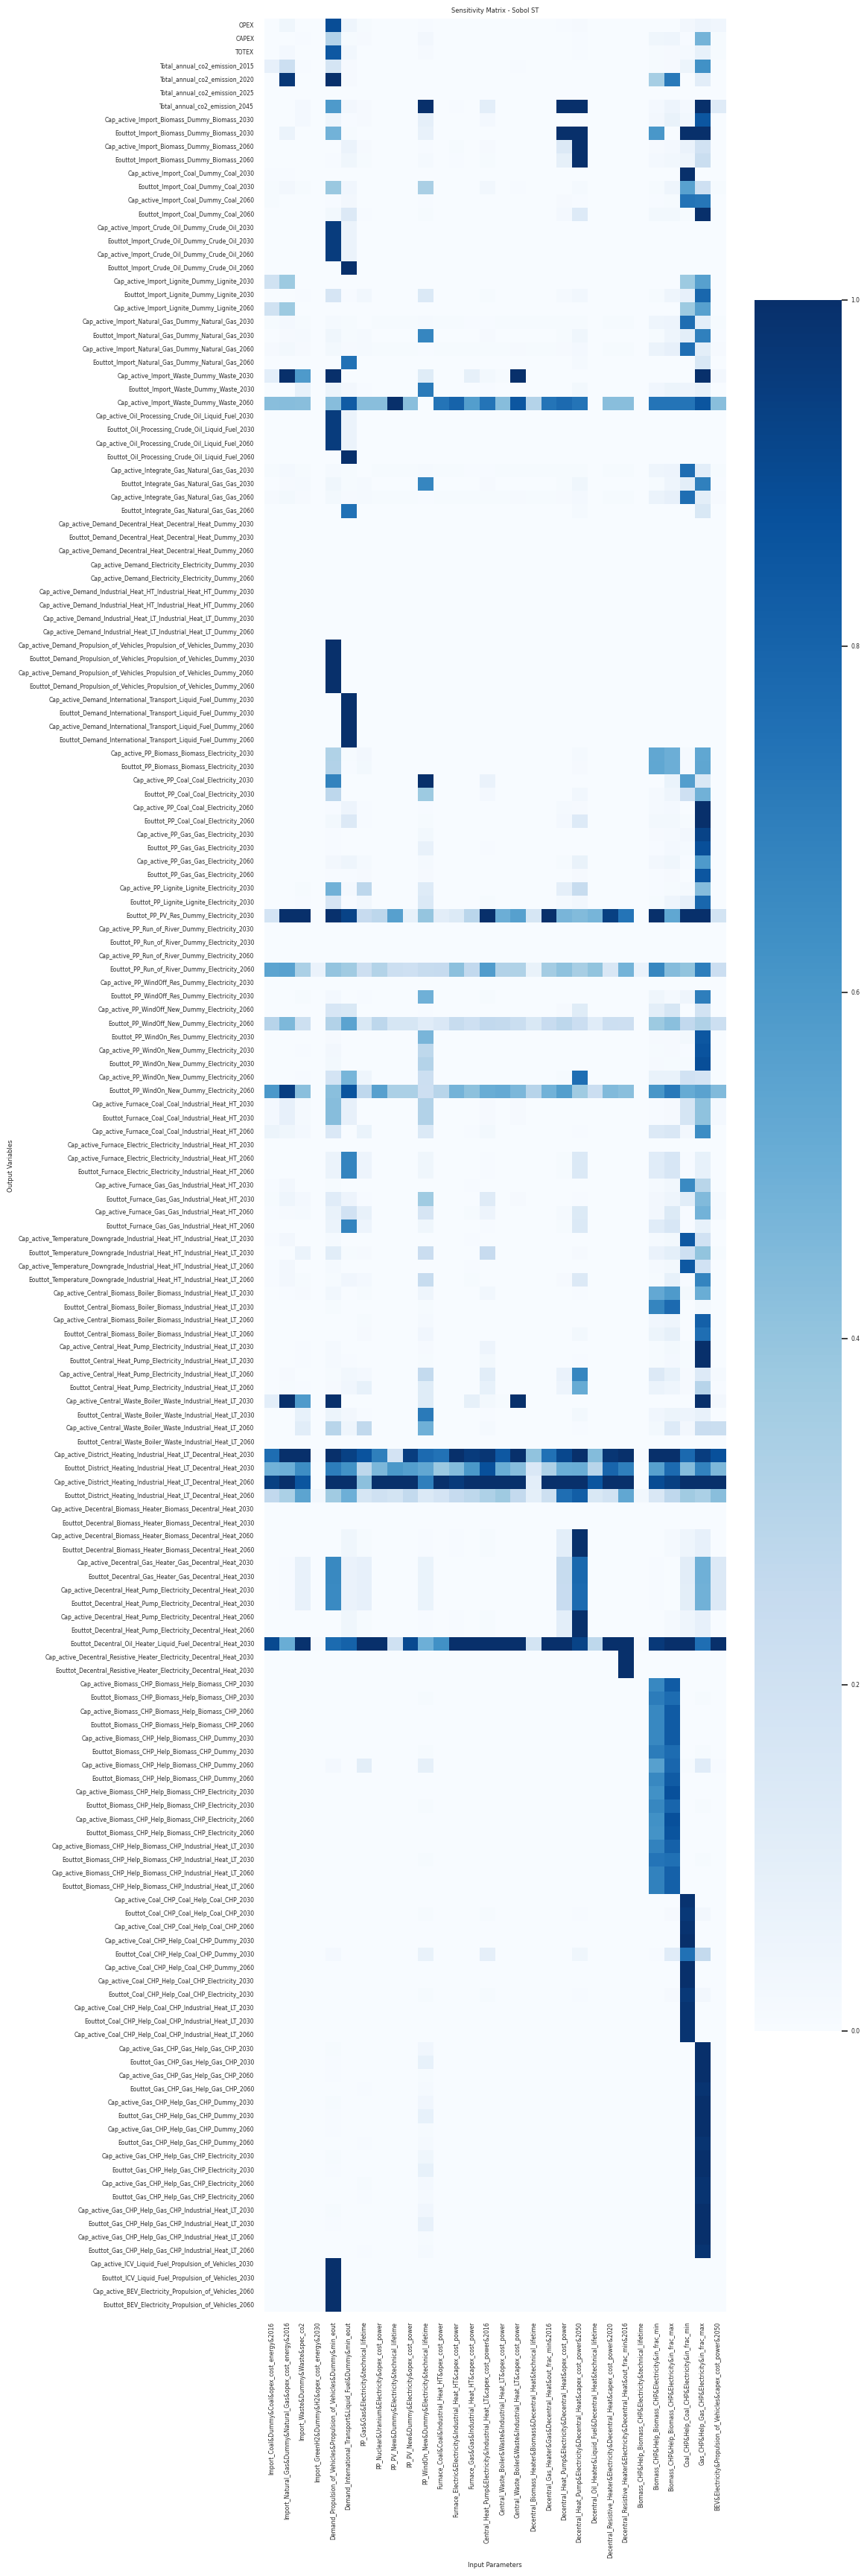

In [12]:
# Plot heatmap
plt.figure(figsize=(10, 40))
sns.set(font_scale=0.5)
sns.heatmap(df_ST.dropna(), annot=False, cmap=sns.color_palette("Blues", as_cmap=True), fmt=".2f", vmin=0, vmax=1)
plt.title('Sensitivity Matrix - Sobol ST')
plt.xlabel('Input Parameters')
plt.ylabel('Output Variables')
plt.show()

In [87]:
import numpy as np
from SALib.test_functions import Ishigami
from SALib.sample import morris as morris_samp
from SALib.analyze import morris

ishigami_problem ={
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

X_morris = morris_samp.sample(ishigami_problem, 1000, num_levels=4)
Y_morris = Ishigami.evaluate(X_morris)
Si_morris = morris.analyze(ishigami_problem, X_morris, Y_morris, conf_level=0.95, print_to_console=True, num_levels=4)

          mu   mu_star     sigma  mu_star_conf
x1  7.629069  7.629069  6.251473  3.594599e-01
x2 -0.283500  7.875000  7.873833  5.248703e-15
x3 -0.249952  6.248796  8.838017  3.712814e-01


In [ ]:
with open(f'{path}/morris_results.pkl', 'wb') as f:
    pickle.dump(Si, f, protocol=pickle.HIGHEST_PROTOCOL)